Could it be that the missing piece is that we need to band limit the signal? The paper mentions that the vectorized version is essentially the exact transfer function method with the polarisation transfer function tensor in front, and that method has strong aliasing issues. Matsushima and Shimobaba present how to bandlimit the signal in ```Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields```. In this notebook we investigate using this limiting in conjunction with the multislice propagator.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import chromatix.functional as cf
import numpy as np
from jax import Array

from sample import R
from tensor_tomo import outer, matvec
from chromatix.utils.utils import sigmoid_taper
from jax.lax import scan
from jax.typing import ArrayLike
from chromatix.utils.fft import fft, ifft

%config InlineBackend.figure_format='retina'

In [2]:
# Simulation settings
size = (4.55, 11.7, 11.7) # from paper
spacing = 0.065 # [mum], from paper
wavelength = 0.405 # [mum], from paper
n_background = 1.33
n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
polarisation = cf.linear(0) # x-polarised light
k0 = 2 * jnp.pi / wavelength
bead_radius = 1.5 # [mum]
NA = 0.8

In [3]:
# Getting a sample 
def paper_sample() -> Array:
    # Calculating shape
    shape = np.around((np.array(size) / spacing)).astype(int) # without around becomes 1 less!

    # center of pixel is our coordinate
    z = jnp.linspace(1/2*spacing, size[0] - 1/2 * spacing, shape[0])
    y = jnp.linspace(size[1] - 1/2 * spacing, 1/2 * spacing, shape[1])
    x = jnp.linspace(1/2*spacing, size[2] - 1/2 * spacing, shape[2])
    grid = jnp.stack(jnp.meshgrid(z, y, x, indexing="ij"), axis=-1) 

    # Position of each bead, with radius 
    bead_pos = jnp.array([[size[0] / 2, 8.85, 2.85],
                      [size[0] / 2, 8.85, 8.85],
                      [size[0] / 2, 2.85, 2.85],
                      [size[0] / 2, 2.85, 8.85]])
    rotation = jnp.array([[0.0, jnp.pi/2, 0.0], 
                      [0.0, 0.0,0.0],
                      [0.0, 0.0, jnp.pi/2], 
                      [jnp.pi/4, jnp.pi/4, jnp.pi/4]])


    permitivitty = jnp.zeros((*shape, 1, 3, 3))

    # Adding each bead
    for pos, orientation in zip(bead_pos, rotation):
        # Making bead and background
        bead_permitivitty = R(*orientation).T @ jnp.diag(n_bead**2) @ R(*orientation)
        background_permitivitty = jnp.eye(3) * n_background**2

        # Mask
        mask = jnp.sum((grid - pos)**2, axis=-1) < bead_radius ** 2

        # Making sample
        permitivitty += (k0**2 * jnp.where(
            mask[..., None, None, None], background_permitivitty - bead_permitivitty, jnp.zeros((3, 3))
        ))

    return permitivitty

potential = paper_sample()

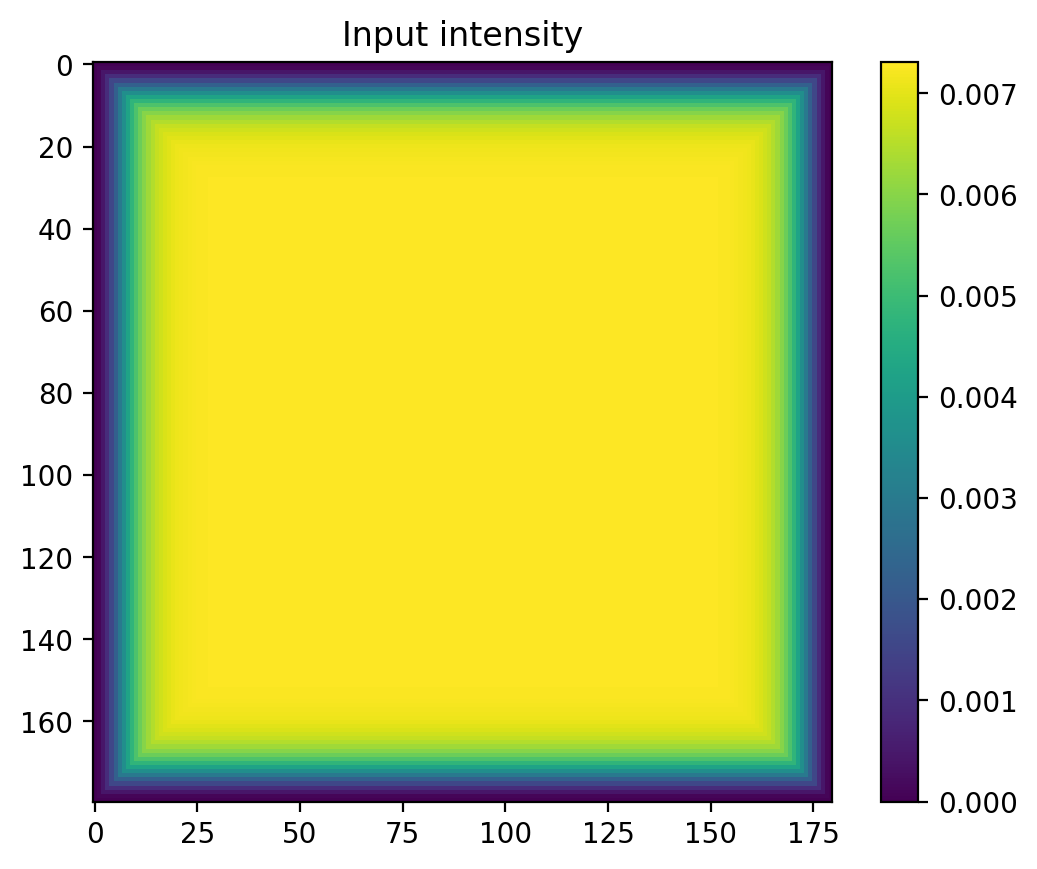

In [22]:
# Making the field 
field = cf.plane_wave((potential.shape[1], potential.shape[2]), spacing, wavelength, 1.0, amplitude=polarisation, scalar=False)

# Adding a little apodisation
field = field.replace(u = field.u * sigmoid_taper((field.shape[1], field.shape[2]), 4))

plt.title("Input intensity")
plt.imshow(field.intensity.squeeze())
plt.colorbar()
plt.show()

In [23]:
# Preliminaries
# To prevent circular convolution, we need to pad the field to field + kernel size.
# the kernel is the size of the field, so the field doubles in size per dim.
# FFT is shift invariant so we just add zeros at the end
padded_shape = 5 * np.array(field.spatial_shape)
n_pad = padded_shape - np.array(field.spatial_shape)
padding = ((0, 0), (0, n_pad[0]), (0, n_pad[1]), (0, 0), (0, 0))

print(f"Padded field shape {padded_shape}")

Padded field shape [900 900]


In [24]:
# Now we can calculate the k-grid
k_grid = 2 * jnp.pi * jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(n=padded_shape[0], d=spacing), jnp.fft.fftfreq(n=padded_shape[1], d=spacing), indexing='ij'))[:, None, ..., None, None]
km = 2 * jnp.pi * n_background / field.spectrum * 0.8 
kz = jnp.sqrt(jnp.maximum(0.0, km**2 - jnp.sum(k_grid**2, axis=0))) # chop off evanescent waves
k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

In [25]:
# Making the polarisation transfer function 
Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)

# This is biggert than -1 and + 1 - a problem; anything bigger than 1 shoudl be zero
print(f"The min and max value of Q:{Q.min():.2f},{Q.max():.2f}")

# doing this based only on x y is numerically more accurate
Q = jnp.where(jnp.sum(k_grid[1:, ..., None]**2, axis=0) <= km**2, Q, 0)
print(f"The min and max value of Q:{Q.min():.2f},{Q.max():.2f}")

The min and max value of Q:-8.57,8.55
The min and max value of Q:-0.50,1.00


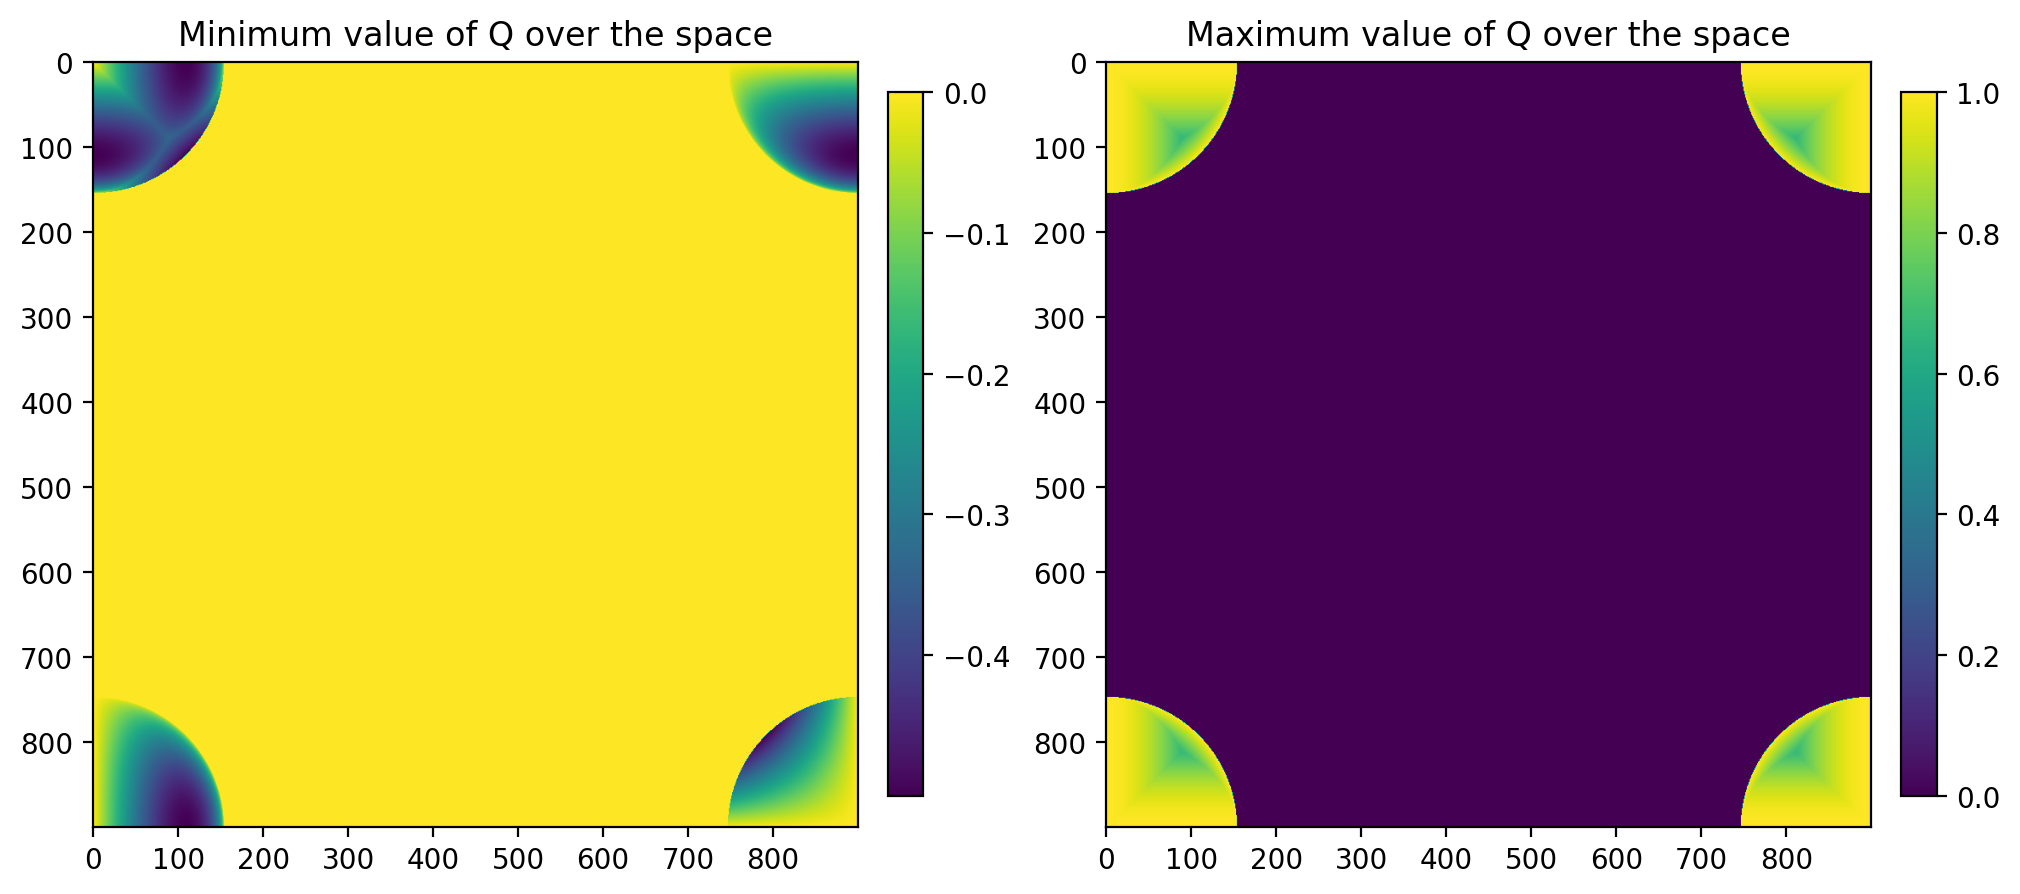

In [26]:
plt.figure(figsize=(10, 5), layout="compressed")
plt.subplot(121)
plt.title("Minimum value of Q over the space")
plt.imshow(jnp.min(Q, axis=(-2, -1)).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.title("Maximum value of Q over the space")
plt.imshow(jnp.max(Q, axis=(-2, -1)).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

We have a good Q which is bandlimited according to `km^2`, but the bandlimited angular spectrum method says we need to bandlimit more to prevent aliasing, mainly due to the oscilations in kz. 

[NOTE: LETS DO THIS IN A BIT.]



In [48]:
def thick_polarised_sample(field: cf.VectorField, potential: ArrayLike, n_background: ArrayLike, dz: ArrayLike) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        return crop(ifft(matvec(Q, fft(pad(u)))))
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        prefactor = jnp.where(kz > 0, -1j / 2 * jnp.exp(1j * kz * dz) / kz  * dz, 0)
        return crop(ifft(matvec(Q, prefactor * fft(pad(u)))))
    
    def P_op(u: Array) -> Array:
        """Vectorial free space operator"""
        prefactor =  jnp.where(kz > 0, jnp.exp(1j * kz * dz), 0)
        return crop(ifft(matvec(Q, prefactor * fft(pad(u)))))

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, None]:
        scatter_field = matvec(potential_slice, Q_op(u))
        new_field = P_op(u) + H_op(scatter_field)
        return new_field, new_field

    def pad(u):
        return jnp.pad(u, padding)

    def crop(u):
        return u[:, :field.spatial_shape[0],  :field.spatial_shape[1]]

    # Padding for circular convolution
    padded_shape = 2 * np.array(field.spatial_shape)
    n_pad = padded_shape - np.array(field.spatial_shape)
    padding = ((0, 0), (0, n_pad[0]), (0, n_pad[1]), (0, 0), (0, 0))

    # Getting k_grid 
    k_grid = 2 * jnp.pi * jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(n=padded_shape[0], d=spacing), jnp.fft.fftfreq(n=padded_shape[1], d=spacing), indexing='ij'))[:, None, ..., None, None]
    km = 2 * jnp.pi * n_background / field.spectrum
    kz = jnp.sqrt(jnp.maximum(0.0, km**2 - jnp.sum(k_grid**2, axis=0))) # chop off evanescent waves
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Getting PTFT and band limiting
    Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)
    Q = jnp.where(jnp.sum(k_grid[1:, ..., None]**2, axis=0) <= NA**2 * km**2, Q, 0) # Add the NA here
    
    # Running scan over sample
    u, intermediates = scan(propagate_slice, field.u, potential)
    return field.replace(u=u), intermediates

In [49]:
out_field, intermediates = thick_polarised_sample(field, potential, n_background, spacing)
amplitude = out_field.amplitude.squeeze()
phase = out_field.phase.squeeze()

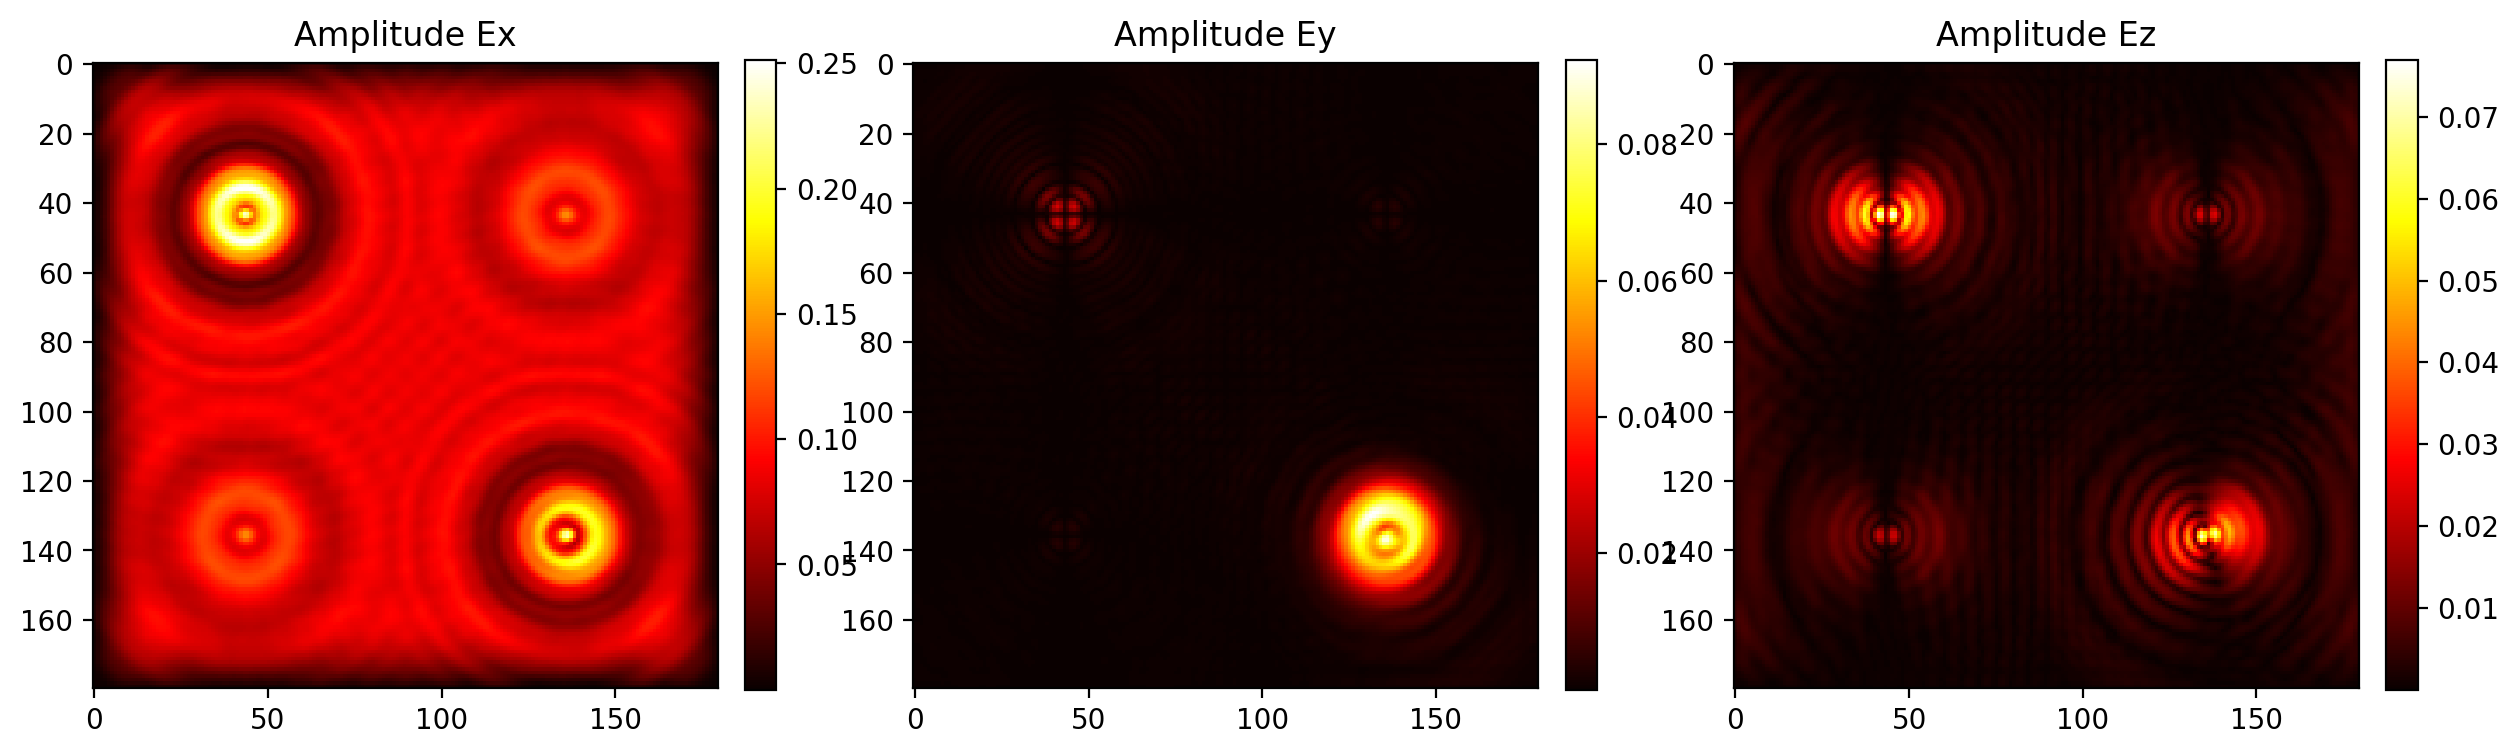

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

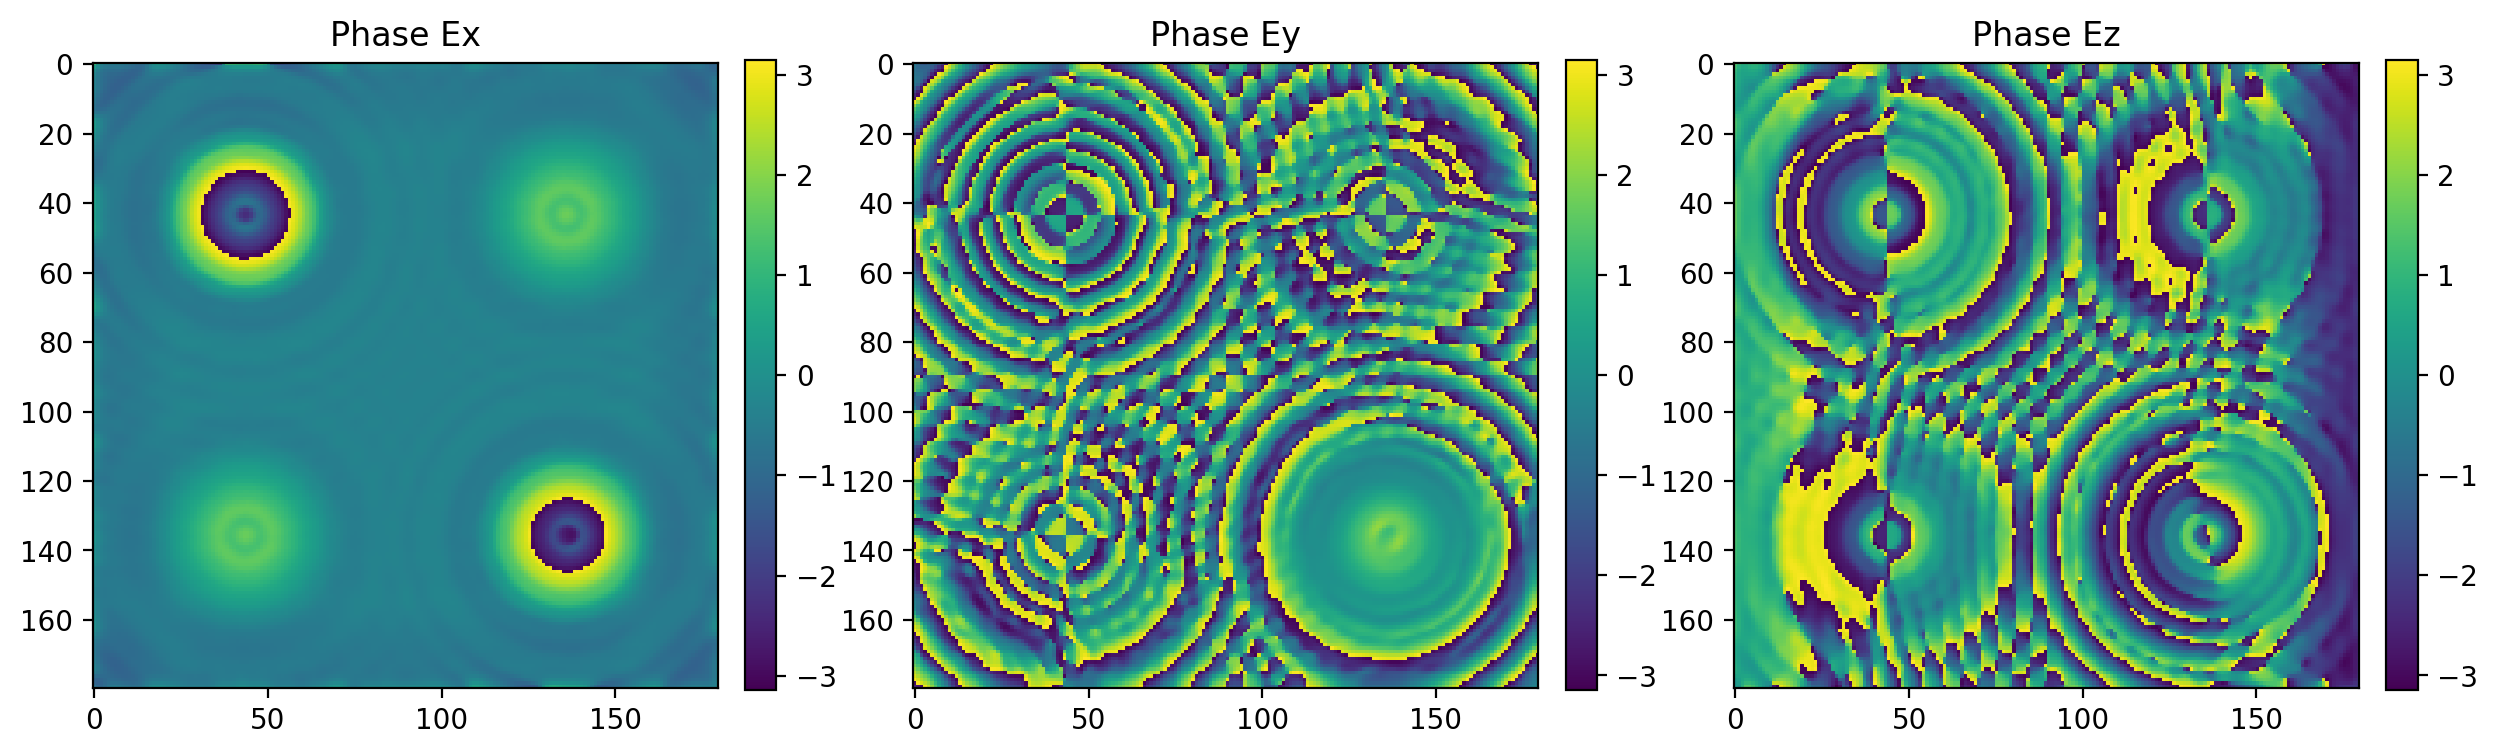

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)

In [52]:
intermediates.shape

(70, 1, 180, 180, 1, 3)

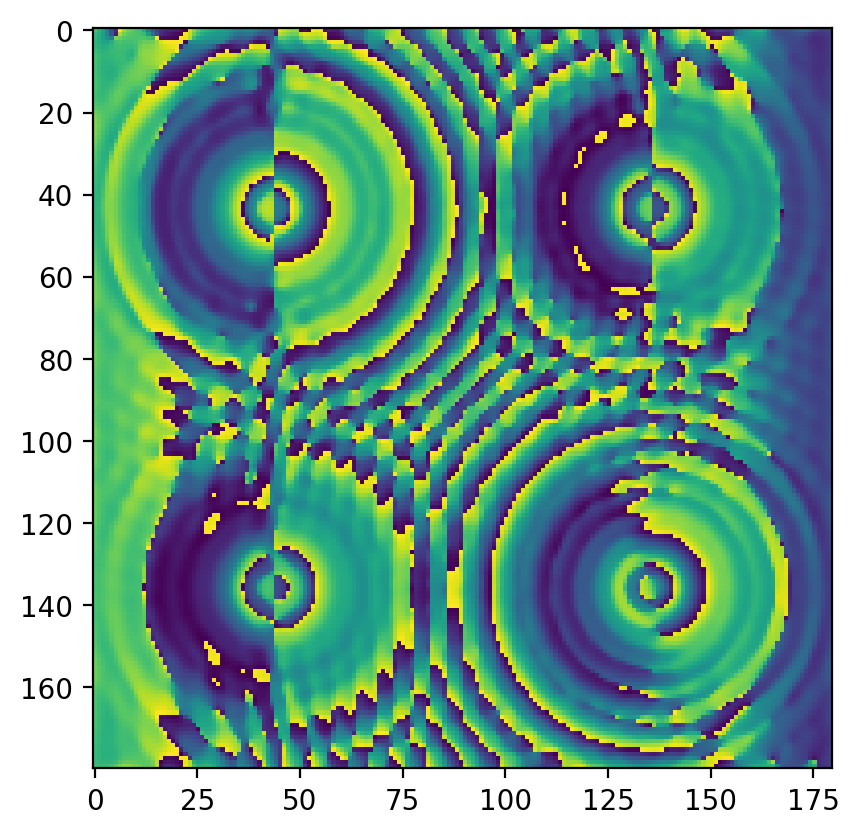

In [68]:
plt.imshow(jnp.angle(intermediates[60]).squeeze()[..., 0])